In [19]:
# Install Kaggle API if not installed
!pip install kaggle --upgrade

# Make sure the Kaggle API key is in the correct directory
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

# Download the dataset
!kaggle datasets download -d myylee/cxr8-selected --unzip

Dataset URL: https://www.kaggle.com/datasets/myylee/cxr8-selected
License(s): apache-2.0
100% 42.0G/42.0G [27:44<00:00, 28.3MB/s]
100% 42.0G/42.0G [27:44<00:00, 27.1MB/s]


In [20]:
import pandas as pd

# Load metadata
data_entry_df = pd.read_csv("Data_Entry_2017.csv")
bbox_df = pd.read_csv("BBox_List_2017.csv")

# Display first few rows
print("Data Entry CSV:")
print(data_entry_df.head())

print("\nBounding Box CSV:")
print(bbox_df.head())

Data Entry CSV:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1       

In [45]:
# Automatically find all PNG images inside subfolders
image_files = glob.glob("images/**/*.png", recursive=True)

# Extract only filenames (to match the CSV file)
available_images = set([os.path.basename(f) for f in image_files])

# Update dataset to check which images exist
data_entry_df["Exists"] = data_entry_df["Image Index"].isin(available_images)

# ✅ Print updated results
print("\n✅ Updated Image Availability Check:")
print(data_entry_df["Exists"].value_counts())



✅ Updated Image Availability Check:
Exists
True    112120
Name: count, dtype: int64


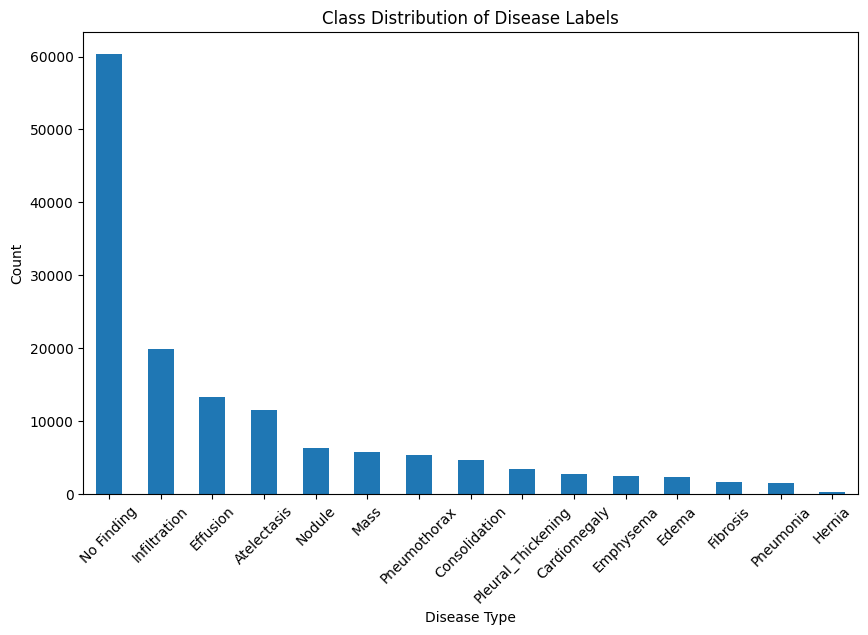

In [21]:
import matplotlib.pyplot as plt

# Split labels (each image may have multiple diseases)
all_labels = data_entry_df["Finding Labels"].str.split("|", expand=True).stack().value_counts()

# Plot label distribution
plt.figure(figsize=(10, 6))
all_labels.plot(kind="bar")
plt.title("Class Distribution of Disease Labels")
plt.xlabel("Disease Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

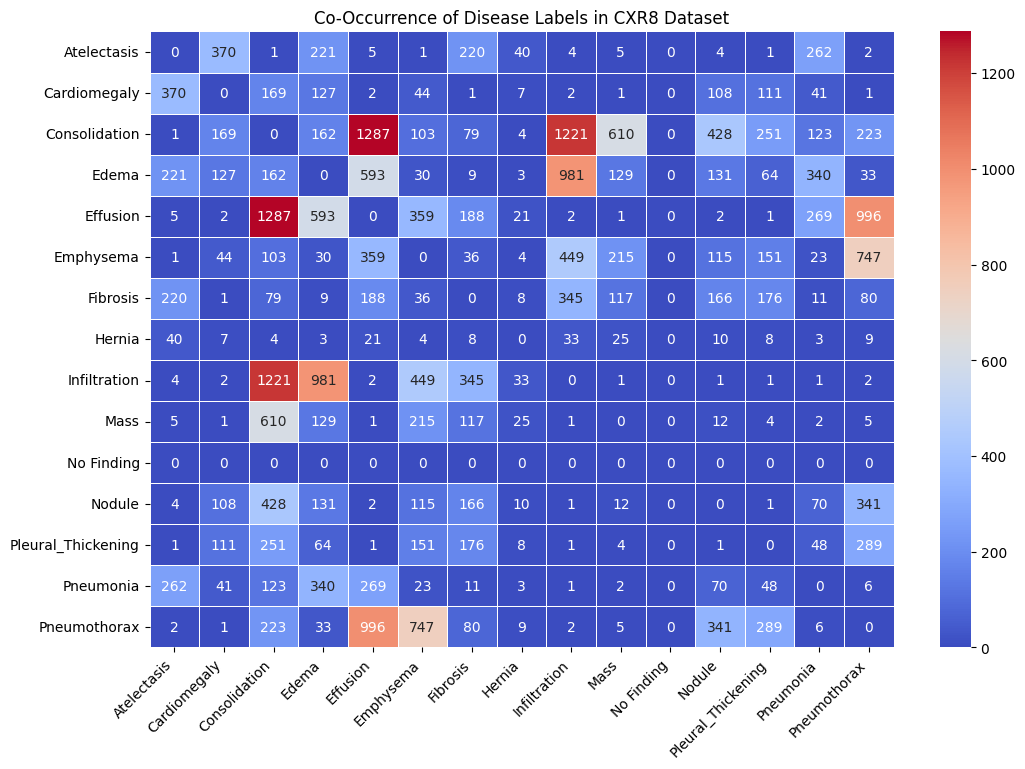

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# Load dataset (update path if needed)
data_entry_df = pd.read_csv("Data_Entry_2017.csv")  # Ensure correct file path

# Ensure labels are split correctly
data_entry_df["Finding Labels"] = data_entry_df["Finding Labels"].apply(lambda x: x.split('|') if isinstance(x, str) else [])

# ✅ Check if dataset contains valid labels
if data_entry_df["Finding Labels"].str.len().sum() == 0:
    print("❌ No valid labels found in dataset. Please check the 'Finding Labels' column.")
else:
    # Generate co-occurrence pairs
    all_pairs = []
    for labels in data_entry_df["Finding Labels"]:
        all_pairs.extend(combinations(labels, 2))  # Create all possible disease label pairs

    # Count co-occurrence frequencies
    pair_counts = Counter(all_pairs)

    # Extract unique disease labels (convert set to sorted list)
    unique_diseases = sorted(set(sum(data_entry_df["Finding Labels"], [])))

    # ✅ Ensure at least two unique diseases exist
    if len(unique_diseases) < 2:
        print("❌ Not enough unique diseases for co-occurrence analysis.")
    else:
        # Create an empty co-occurrence matrix (DataFrame)
        heatmap_df = pd.DataFrame(0, index=unique_diseases, columns=unique_diseases)

        # Populate the co-occurrence matrix
        for (disease1, disease2), count in pair_counts.items():
            heatmap_df.loc[disease1, disease2] = count
            heatmap_df.loc[disease2, disease1] = count  # Ensure symmetry

        # ✅ Only plot heatmap if it contains values
        if heatmap_df.values.sum() == 0:
            print("⚠️ No co-occurrence data available.")
        else:
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_df, annot=True, fmt=".0f", cmap="coolwarm", linewidths=0.5)
            plt.title("Co-Occurrence of Disease Labels in CXR8 Dataset")
            plt.xticks(rotation=45, ha="right")
            plt.yticks(rotation=0)
            plt.show()

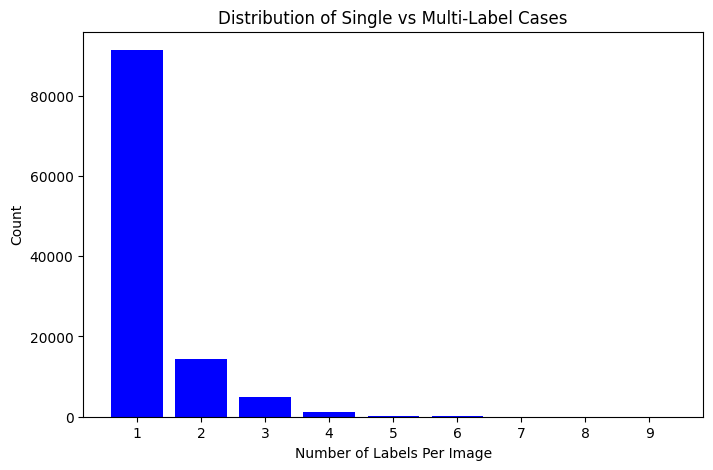

In [56]:
# Count single vs multi-label occurrences
data_entry_df["Label Count"] = data_entry_df["Finding Labels"].apply(len)
label_distribution = data_entry_df["Label Count"].value_counts().sort_index()

# Plot distribution of single-label vs multi-label cases
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(label_distribution.index, label_distribution.values, color="blue")
plt.xlabel("Number of Labels Per Image")
plt.ylabel("Count")
plt.title("Distribution of Single vs Multi-Label Cases")
plt.xticks(range(1, max(label_distribution.index) + 1))
plt.show()

In [24]:
# ✅ STEP 5: Disease Co-occurrence Heatmap
disease_list = all_labels.index.tolist()

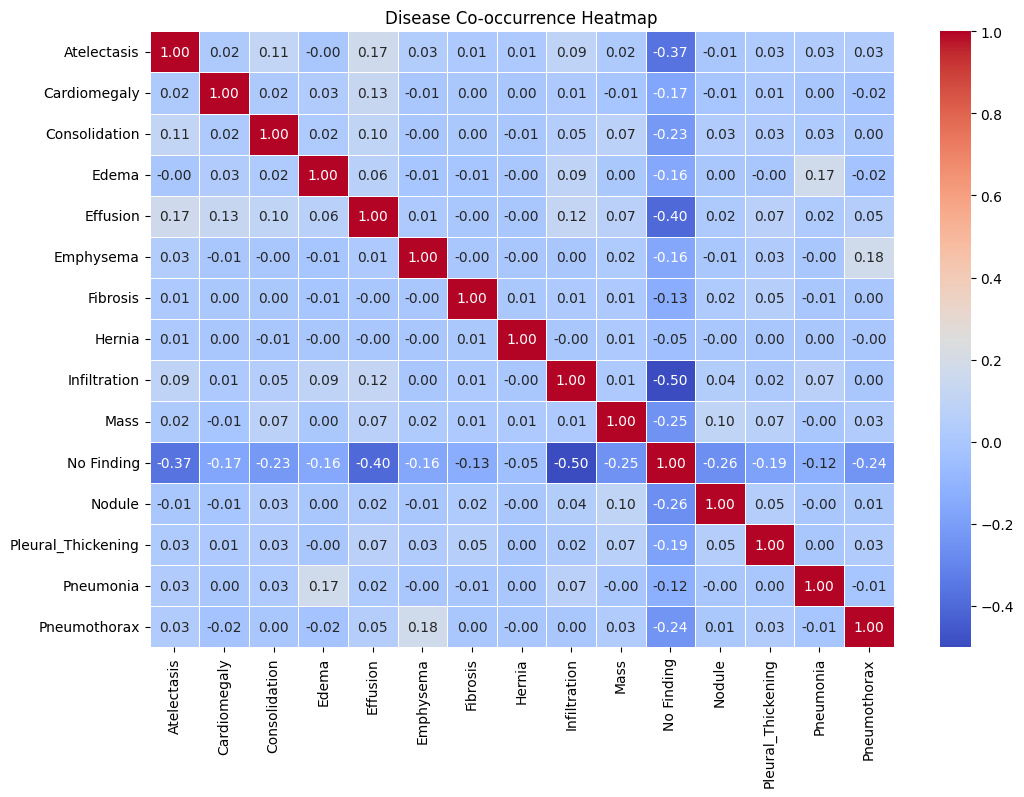

In [27]:
!pip install seaborn
import seaborn as sns

disease_matrix = data_entry_df["Finding Labels"].str.get_dummies(sep="|")
correlation_matrix = disease_matrix.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Disease Co-occurrence Heatmap")
plt.show()

<ipython-input-28-eb3b50b73469>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_entry_df["Patient Gender"], palette="pastel")


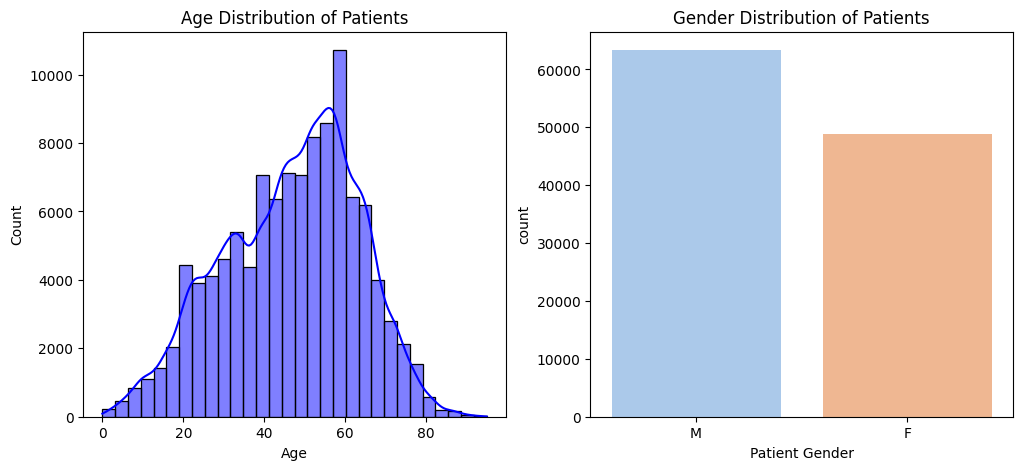

In [28]:
if "Patient Age" in data_entry_df.columns and "Patient Gender" in data_entry_df.columns:
    plt.figure(figsize=(12, 5))

    # Age Distribution
    plt.subplot(1, 2, 1)
    sns.histplot(data_entry_df["Patient Age"], bins=30, kde=True, color="blue")
    plt.title("Age Distribution of Patients")
    plt.xlabel("Age")
    plt.ylabel("Count")

    # Gender Distribution
    plt.subplot(1, 2, 2)
    sns.countplot(x=data_entry_df["Patient Gender"], palette="pastel")
    plt.title("Gender Distribution of Patients")

    plt.show()
else:
    print("❌ Patient Age and Gender data not available in this dataset!")

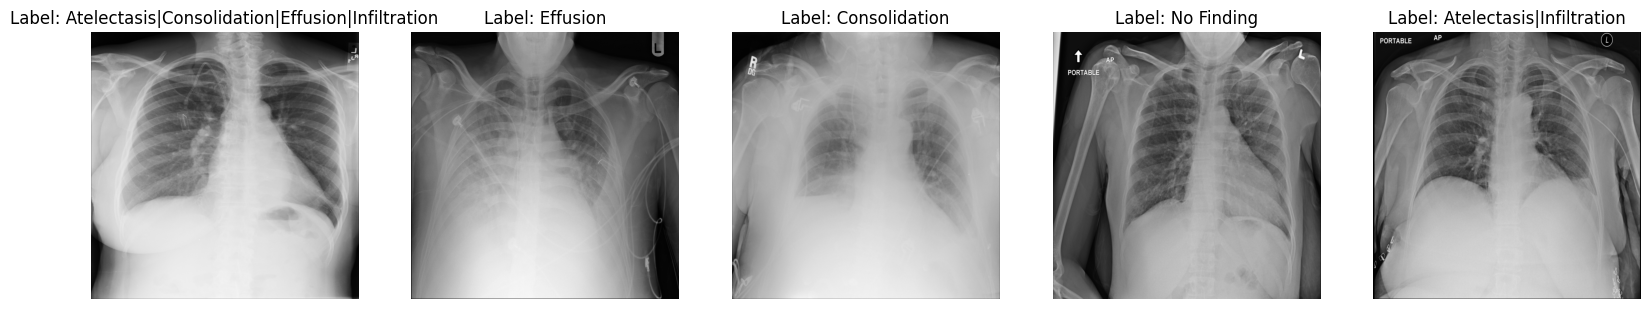

In [46]:
def show_multiple_sample_images(n=5):
    """Displays multiple random X-ray images with labels."""

    # Filter dataset to only images that exist
    valid_images_df = data_entry_df[data_entry_df["Exists"] == True]

    if valid_images_df.empty:
        print("❌ No valid images found. Check dataset path or missing images.")
        return

    fig, axes = plt.subplots(1, n, figsize=(20, 5))

    for i in range(n):
        # Select a random valid image
        sample = valid_images_df.sample(1)[["Image Index", "Finding Labels"]].values[0]
        sample_filename = sample[0]

        # Find the actual path in the nested folders
        matching_files = glob.glob(f"images/**/{sample_filename}", recursive=True)

        if len(matching_files) > 0:
            img_path = matching_files[0]
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            axes[i].imshow(image, cmap="gray")
            axes[i].set_title(f"Label: {sample[1]}")
            axes[i].axis("off")
        else:
            print(f"❌ Image {sample_filename} not found in dataset folders.")

    plt.show()

# ✅ Try displaying images again
show_multiple_sample_images(n=5)


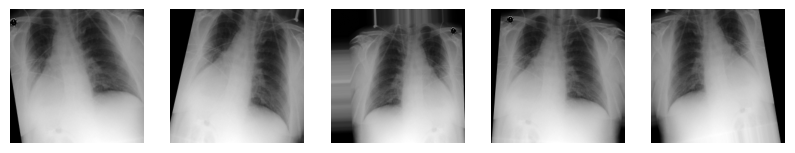

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Initialize ImageDataGenerator with Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

# ✅ Load a Sample Image
sample_img_path = image_files[0]  # Ensure image_files list is defined
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
sample_img_resized = cv2.resize(sample_img, (224, 224))

# ✅ Apply Data Augmentation
sample_img_expanded = np.expand_dims(sample_img_resized, axis=(0, -1))  # Expand dimensions for batch processing
aug_iter = datagen.flow(sample_img_expanded, batch_size=1)

# ✅ Display Augmented Images
plt.figure(figsize=(10, 4))
for i in range(5):
    batch = next(aug_iter)
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0].squeeze(), cmap="gray")
    plt.axis("off")

plt.show()
